In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as m_a_e, mean_squared_error as m_s_e, r2_score as r2
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lime import lime_tabular

from scipy.stats.mstats import winsorize

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#dataset = "E:/Formation Data Scientist/Projet_4/2016_Building_Energy_Benchmarking.csv"

In [5]:
_df_ = pd.read_csv('clean_df.csv')

In [6]:
_df_.describe()

,Unnamed: 0,Latitude,Longitude,NumberofBuildings,NumberofFloors,ENERGYSTARScore,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,967.000000,1.440000e+03,1440.000000,1.436000e+03,1440.000000,1440.000000,1440.000000,1440.000000,1.440000e+03
mean,728.482639,47.615850,-122.333765,1.112500,4.349306,63.749741,1.023572e+05,14418.843056,9.455830e+04,0.067361,0.997917,0.712500,177.627243,8.002949e+06
std,421.522776,0.046946,0.023199,1.221129,6.759201,28.806512,1.770243e+05,44731.415406,1.629127e+05,0.250733,0.045612,0.452754,609.768933,1.856069e+07
min,0.000000,47.509590,-122.411820,0.000000,0.000000,1.000000,3.636000e+03,0.000000,5.656000e+03,0.000000,0.000000,0.000000,-0.800000,5.713320e+04
25%,362.750000,47.586950,-122.342740,1.000000,1.000000,44.000000,2.849800e+04,0.000000,2.561000e+04,0.000000,1.000000,0.000000,19.887500,1.240258e+06
50%,729.500000,47.612335,-122.333280,1.000000,3.000000,71.000000,4.687900e+04,0.000000,4.303300e+04,0.000000,1.000000,1.000000,49.040000,2.695255e+06
75%,1092.250000,47.648240,-122.323520,1.000000,5.000000,88.000000,9.626550e+04,0.000000,9.279725e+04,0.000000,1.000000,1.000000,142.052500,7.267172e+06
max,1465.000000,47.733870,-122.261800,27.000000,99.000000,100.000000,2.200000e+06,512608.000000,1.719643e+06,1.000000,1.000000,1.000000,12307.160000,2.930908e+08


In [7]:
clean_df = _df_.drop(columns=['ENERGYSTARScore','Unnamed: 0']).copy()

In [8]:
clean_df.dropna(inplace=True)

In [9]:
clean_df.isna().sum()

PrimaryPropertyType          0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
LargestPropertyUseTypeGFA    0
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
SiteEnergyUse(kBtu)          0
dtype: int64

In [10]:
clean_df.dtypes

PrimaryPropertyType           object
Latitude                     float64
Longitude                    float64
YearBuilt                     object
NumberofBuildings            float64
NumberofFloors                 int64
PropertyGFABuilding(s)         int64
PropertyGFAParking             int64
LargestPropertyUseTypeGFA    float64
SteamUse(kBtu)                 int64
Electricity(kBtu)              int64
NaturalGas(kBtu)               int64
TotalGHGEmissions            float64
SiteEnergyUse(kBtu)          float64
dtype: object

In [11]:
clean_df

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
0,Hotel,47.61220,-122.33799,1920_1940,1.0,12,88434,0,88434.0,1,1,1,249.98,7226362.50
1,Hotel,47.61317,-122.33393,1980_2000,1.0,11,88502,15064,83880.0,0,1,1,295.86,8387933.00
2,Hotel,47.61393,-122.33810,1960_1980,1.0,41,759392,196718,756493.0,1,1,1,2089.28,72587024.00
3,Hotel,47.61412,-122.33664,1920_1940,1.0,10,61320,0,61320.0,1,1,1,286.43,6794584.00
4,Hotel,47.61375,-122.34047,1960_1980,1.0,18,113580,62000,123445.0,0,1,1,505.01,14172606.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,Warehouse,47.54425,-122.31776,1940_1960,1.0,1,47863,4222,52085.0,0,1,1,157.70,3605855.50
1436,Small- and Mid-Sized Office,47.53161,-122.29944,1920_1940,1.0,2,24990,0,24990.0,0,1,1,134.80,4420650.50
1437,Other,47.68109,-122.26180,2000_,1.0,1,72000,0,72000.0,0,1,1,67.65,2925780.00
1438,K-12 School,47.58831,-122.30650,2000_,1.0,3,45000,0,45728.0,0,1,0,9.24,1325972.75


In [12]:
clean_df = clean_df.reset_index(drop=True)

- Conversion des features catégorielles

In [13]:
df_encoded = pd.get_dummies(clean_df ,columns=['PrimaryPropertyType','YearBuilt'])

In [14]:
df_encoded

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),...,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,YearBuilt_1920_1940,YearBuilt_1940_1960,YearBuilt_1960_1980,YearBuilt_1980_2000,YearBuilt_2000_,YearBuilt__1920
0,47.61220,-122.33799,1.0,12,88434,0,88434.0,1,1,1,...,0,0,0,0,1,0,0,0,0,0
1,47.61317,-122.33393,1.0,11,88502,15064,83880.0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
2,47.61393,-122.33810,1.0,41,759392,196718,756493.0,1,1,1,...,0,0,0,0,0,0,1,0,0,0
3,47.61412,-122.33664,1.0,10,61320,0,61320.0,1,1,1,...,0,0,0,0,1,0,0,0,0,0
4,47.61375,-122.34047,1.0,18,113580,62000,123445.0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,47.54425,-122.31776,1.0,1,47863,4222,52085.0,0,1,1,...,0,0,1,0,0,1,0,0,0,0
1432,47.53161,-122.29944,1.0,2,24990,0,24990.0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
1433,47.68109,-122.26180,1.0,1,72000,0,72000.0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
1434,47.58831,-122.30650,1.0,3,45000,0,45728.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [15]:
features = df_encoded.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"])

In [16]:
features_names = features.columns

In [17]:
features_names

Index(['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFABuilding(s)', 'PropertyGFAParking',
       'LargestPropertyUseTypeGFA', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Restaurant', 'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Community',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehou

In [18]:
train, test = train_test_split(df_encoded, test_size=0.33, random_state=3) 

In [19]:
X1_train, y1_train, X1_test, y1_test = train.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"]), train["TotalGHGEmissions"],test.drop(columns = ["TotalGHGEmissions",'SiteEnergyUse(kBtu)']) ,test["TotalGHGEmissions"]

## <a name='C2'> Prédictions de TotalGHGEmissions   </a>

In [20]:
""" scaler = StandardScaler()
scaler.fit(X1_train)
X1_train = scaler.transform(X1_train)
X1_test = scaler.transform(X1_test) """

' scaler = StandardScaler()\nscaler.fit(X1_train)\nX1_train = scaler.transform(X1_train)\nX1_test = scaler.transform(X1_test) '

### <a name='C2'> GridSearch CV   </a>

In [21]:
def get_errors(y_test,y_pred):
    rmse = m_s_e(y_test, y_pred,squared=False)
    mae = m_a_e(y_test, y_pred)
    r_2 = r2(y_test,y_pred)
    mean_ = np.mean(y1_test)
    return (r_2, rmse, mae, mean_)

### - Dummy Regressor

In [22]:
dummy_param_grid = {'strategy' : ['mean','median']}

In [23]:
CV_dummy_mean = GridSearchCV(estimator=DummyRegressor(), param_grid=dummy_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_dummy_mean.fit(X1_train, y1_train)

GridSearchCV(cv=5, estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [24]:
CV_dummy_mean.best_score_

-0.0034844845202935738

In [25]:
dummy_model = CV_dummy_mean.best_estimator_

In [26]:
dummy_model.score(X1_test,y1_test)

-4.482239549297162e-06

In [27]:
print(f"Validation Score: {round(CV_dummy_mean.best_score_*100,2)} %")
print(f"Score - training data: {round(CV_dummy_mean.score(X1_train,y1_train)*100,2)} %")
print(f"Score - test data: {round(CV_dummy_mean.score(X1_test,y1_test)*100,2)} %")

Validation Score: -0.35 %
Score - training data: 0.0 %
Score - test data: -0.0 %


In [28]:
results_dummy = pd.DataFrame(CV_dummy_mean.cv_results_)

### - Random Forest Regressor


In [29]:
rfr_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              #'max_depth' : [4,5,6,7,8],
              'n_jobs': [-1],
              'random_state': [1]}

In [30]:
CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rfr_param_grid, cv= 5,scoring=['r2','neg_mean_squared_error','neg_root_mean_squared_error'],refit='r2')
CV_rfr.fit(X1_train, y1_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'n_jobs': [-1], 'random_state': [1]},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error'])

In [31]:
CV_rfr.best_params_

{'max_features': 'sqrt', 'n_estimators': 100, 'n_jobs': -1, 'random_state': 1}

In [32]:
CV_rfr.best_score_

0.5437108442457855

In [33]:
rfr_model= CV_rfr.best_estimator_

In [34]:
rfr_model.score(X1_test,y1_test)

0.6643197997038615

In [35]:
print(f"Validation Score: {round(CV_rfr.best_score_*100,2)} %")
print(f"Score - training data: {round(CV_rfr.score(X1_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_rfr.score(X1_test,y1_test)*100,1)} %")

Validation Score: 54.37 %
Score - training data: 93.6 %
Score - test data: 66.4 %


In [36]:
results_forest = pd.DataFrame(CV_rfr.cv_results_)

### - Ridge Regressor

In [37]:
ridge_param_grid = {'alpha' : [1e-3, 1e-2, 1e-1, 1, 2, 5, 10],
                    'solver':['auto','svd','lsqr','sag'],
                    'random_state': [0]
                    }

In [38]:
CV_ridge = GridSearchCV(estimator=Ridge(), param_grid=ridge_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_ridge.fit(X1_train, y1_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2, 5, 10],
                         'random_state': [0],
                         'solver': ['auto', 'svd', 'lsqr', 'sag']},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [39]:
CV_ridge.best_params_

{'alpha': 0.1, 'random_state': 0, 'solver': 'auto'}

In [40]:
CV_ridge.best_score_

0.5406414814103069

In [41]:
model_ridge = CV_ridge.best_estimator_
print(model_ridge)

Ridge(alpha=0.1, random_state=0)


In [42]:
model_ridge.score(X1_test,y1_test)

0.7437697149162279

In [43]:
print(f"Validation Score: {round(CV_ridge.best_score_*100,2)} %")
print(f"Score - training data: {round(CV_ridge.score(X1_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_ridge.score(X1_test,y1_test)*100,1)} %")

Validation Score: 54.06 %
Score - training data: 66.7 %
Score - test data: 74.4 %


In [44]:
results_ridge = pd.DataFrame(CV_ridge.cv_results_)

### - KNN Regressor

In [45]:
knn_param_grid = {'n_neighbors' : list(range(10, 100)),
              }

In [46]:
CV_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=knn_param_grid, cv= 6,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_knn.fit(X1_train, y1_train)

GridSearchCV(cv=6, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                         30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [47]:
CV_knn.best_score_

0.27258125947669454

In [48]:
model_knn = CV_knn.best_estimator_

In [49]:
model_knn.score(X1_test,y1_test)

0.19570099853974698

In [50]:
print(f"Validation Score: {round(CV_knn.best_score_*100,2)} %")
print(f"Score - training data: {round(CV_knn.score(X1_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_knn.score(X1_test,y1_test)*100,1)} %")

Validation Score: 27.26 %
Score - training data: 20.7 %
Score - test data: 19.6 %


In [51]:
CV_knn.best_params_

{'n_neighbors': 76}

In [52]:
res_knn = pd.DataFrame(CV_knn.cv_results_)

### - XGBoost

In [53]:
xgboost_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              #'max_depth' : [4,5,6,7,8],
              'random_state': [0]}

In [54]:
CV_xgboost = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_xgboost.fit(X1_train, y1_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [0]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [55]:
CV_xgboost.best_params_

{'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 0}

In [56]:
CV_xgboost.best_score_

0.5965984108948367

In [57]:
model_boosted = CV_xgboost.best_estimator_

In [58]:
model_boosted.score(X1_test,y1_test)

0.8344638067931152

In [59]:
print(f"Validation Score: {round(CV_xgboost.best_score_*100,2)} %")
print(f"Score - training data: {round(CV_xgboost.score(X1_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_xgboost.score(X1_test,y1_test)*100,1)} %")

Validation Score: 59.66 %
Score - training data: 97.8 %
Score - test data: 83.4 %


In [60]:
y_pred = model_boosted.predict(X1_test)

In [61]:
predictions = pd.DataFrame({'Actual': y1_test,
                           'Predicted': y_pred})

In [62]:
predictions

,Actual,Predicted
823,92.45,36.615569
1241,1.59,-17.682929
332,247.35,554.271603
602,11.14,61.713162
150,70.15,142.534059
...,...,...
1328,4.80,68.930742
1014,9.71,55.884804
675,65.65,18.780057
648,43.45,41.026119


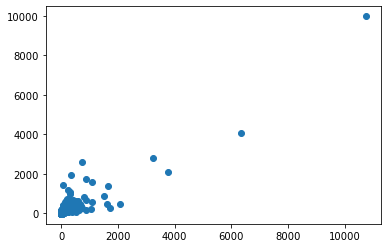

In [63]:
plt.scatter(predictions['Actual'],predictions['Predicted'])

In [64]:
get_errors(y1_test,y_pred)

(0.8344638067931152, 263.1373522326559, 106.17696212001921, 177.0292194092826)

In [65]:
CV_xgboost.best_params_

{'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 0}

In [66]:
print(f"Score - training data: {round(CV_xgboost.score(X1_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_xgboost.score(X1_test,y1_test)*100,1)} %")

Score - training data: 97.8 %
Score - test data: 83.4 %


    Feature Importance                                     Feature Name
2             0.256940                                NumberofBuildings
6             0.227533                        LargestPropertyUseTypeGFA
11            0.181952                     PrimaryPropertyType_Hospital
3             0.079081                                   NumberofFloors
4             0.066281                           PropertyGFABuilding(s)
1             0.043094                                        Longitude
7             0.032477                                   SteamUse(kBtu)
14            0.019186                   PrimaryPropertyType_Laboratory
9             0.016715                                 NaturalGas(kBtu)
32            0.016130                              YearBuilt_1980_2000
0             0.011382                                         Latitude
5             0.010876                               PropertyGFAParking
15            0.008953                 PrimaryPropertyType_Large

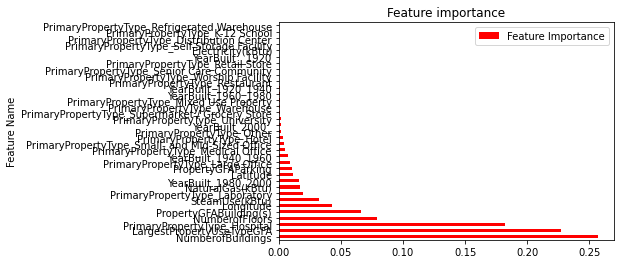

In [67]:
def display_feat_imp_xgboost(boosted):
  feat_imp = model_boosted.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = features_names
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 
display_feat_imp_xgboost(model_boosted)

- <a name='C2'> LIME </a>

In [68]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [69]:
reversed_X1_train = undummify(X1_train)
reversed_X1_test =undummify(X1_test)

In [70]:
label_encoder1 = LabelEncoder().fit(reversed_X1_train['PrimaryPropertyType'])
reversed_X1_train.PrimaryPropertyType = label_encoder1.transform(reversed_X1_train['PrimaryPropertyType'])
reversed_X1_test.PrimaryPropertyType = label_encoder1.transform(reversed_X1_test['PrimaryPropertyType'])

In [71]:
label_encoder2 = LabelEncoder().fit(reversed_X1_train['YearBuilt'])
reversed_X1_train.YearBuilt = label_encoder2.transform(reversed_X1_train['YearBuilt'])
reversed_X1_test.YearBuilt = label_encoder2.transform(reversed_X1_test['YearBuilt'])

In [72]:
dict(zip(label_encoder1.classes_, label_encoder1.transform(label_encoder1.classes_)))


{'Distribution Center': 0,
 'Hospital': 1,
 'Hotel': 2,
 'K-12 School': 3,
 'Laboratory': 4,
 'Large Office': 5,
 'Medical Office': 6,
 'Mixed Use Property': 7,
 'Other': 8,
 'Refrigerated Warehouse': 9,
 'Restaurant': 10,
 'Retail Store': 11,
 'Self-Storage Facility': 12,
 'Senior Care Community': 13,
 'Small- and Mid-Sized Office': 14,
 'Supermarket / Grocery Store': 15,
 'University': 16,
 'Warehouse': 17,
 'Worship Facility': 18}

In [73]:
dict(zip(label_encoder2.classes_, label_encoder2.transform(label_encoder2.classes_)))


{'1920_1940': 0,
 '1940_1960': 1,
 '1960_1980': 2,
 '1980_2000': 3,
 '2000_': 4,
 '_1920': 5}

In [74]:
CV_xgboost.fit(reversed_X1_train, y1_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [0]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [75]:
explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(reversed_X1_train),
                                                   feature_names=reversed_X1_train.columns,
                                                   mode="regression",
                                                   feature_selection='auto',
                                                   random_state=0)

In [76]:
_exp = explainer.explain_instance(data_row=pd.DataFrame(reversed_X1_test).iloc[250],
                                           predict_fn=CV_xgboost.predict)

In [77]:
_exp.show_in_notebook(show_table=True)

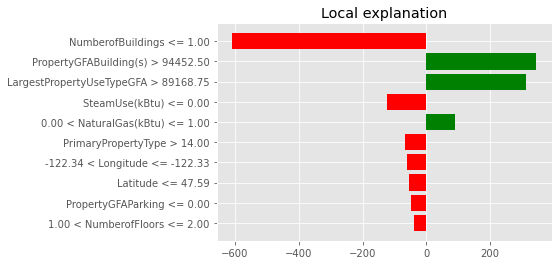

In [247]:
with plt.style.context("ggplot"):
    _exp.as_pyplot_figure()

- <a name='C2'> SHAP </a>

In [78]:
shap_model = CV_xgboost.best_estimator_
shap_explainer  = shap.TreeExplainer(shap_model,reversed_X1_train)

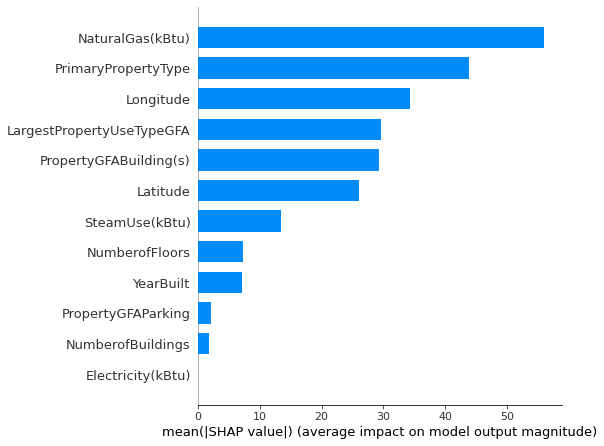

In [79]:
single_shap_value = shap_explainer(reversed_X1_test.sample(n=1))
shap.summary_plot(single_shap_value, feature_names=reversed_X1_train.columns, plot_type='bar')
plt.show()

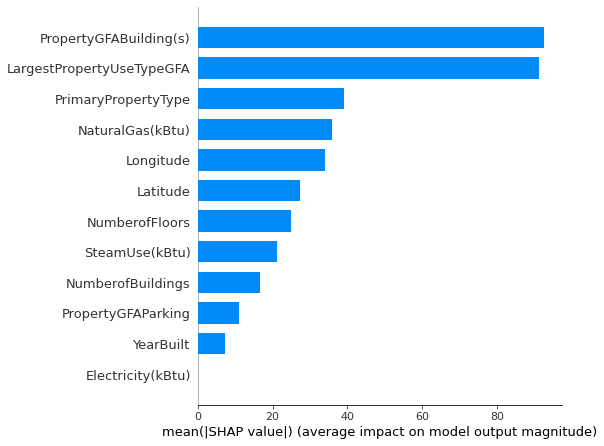

In [248]:
shap_values = shap_explainer(reversed_X1_test,check_additivity = False)
shap.summary_plot(shap_values, feature_names=reversed_X1_train.columns,plot_type='bar')
plt.show()

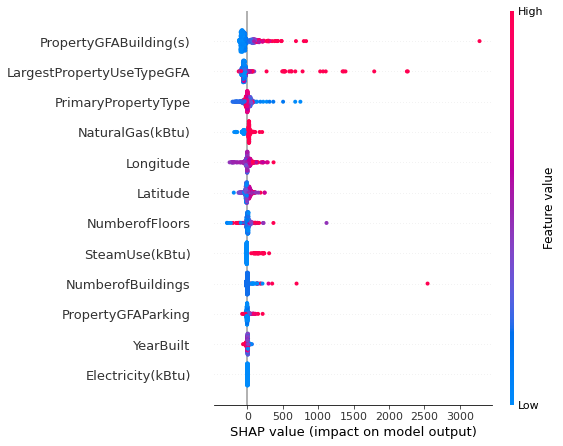

In [80]:
shap_values = shap_explainer(reversed_X1_test,check_additivity = False)
shap.summary_plot(shap_values, feature_names=reversed_X1_train.columns)
plt.show()

Le meilleur modèle choisi est le modèle <a name='C2'>*XGBoost*</a> qui sera utilisé par la suite pour la prédiction de <a name='C2'>*EnergyStarScore*</a>

## <a name='C2'> ENERGYSTARScore   </a>

In [81]:
df_EES = _df_.drop(columns='Unnamed: 0').copy()

In [82]:
df_EES.isna().sum()

PrimaryPropertyType            0
Latitude                       0
Longitude                      0
YearBuilt                      0
NumberofBuildings              0
NumberofFloors                 0
ENERGYSTARScore              473
PropertyGFABuilding(s)         0
PropertyGFAParking             0
LargestPropertyUseTypeGFA      4
SteamUse(kBtu)                 0
Electricity(kBtu)              0
NaturalGas(kBtu)               0
TotalGHGEmissions              0
SiteEnergyUse(kBtu)            0
dtype: int64

In [83]:
df_EES = df_EES.dropna(axis=0)

In [84]:
df_EES.isna().sum()

PrimaryPropertyType          0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
ENERGYSTARScore              0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
LargestPropertyUseTypeGFA    0
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
SiteEnergyUse(kBtu)          0
dtype: int64

In [85]:
df_EES_encoded = pd.get_dummies(df_EES ,columns=['PrimaryPropertyType','YearBuilt'])

- Avec Energy Star Score

In [198]:
train_ESS, test_ESS = train_test_split(df_EES_encoded, test_size=0.33, random_state=2) 

In [199]:
Xe_train, ye_train, Xe_test, ye_test = train_ESS.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"]), train_ESS["TotalGHGEmissions"], test_ESS.drop(columns = ["TotalGHGEmissions",'SiteEnergyUse(kBtu)']) , test_ESS["TotalGHGEmissions"]

In [200]:
""" scaler = StandardScaler()
scaler.fit(Xe_train_ghge)
Xe_train_ghge = scaler.transform(Xe_train_ghge)
Xe_test_ghge = scaler.transform(Xe_test_ghge) """

' scaler = StandardScaler()\nscaler.fit(Xe_train_ghge)\nXe_train_ghge = scaler.transform(Xe_train_ghge)\nXe_test_ghge = scaler.transform(Xe_test_ghge) '

- Entrainement avec les meilleurs paramètres du XGBoost

In [201]:
#xGBoost_ESS = GradientBoostingRegressor(**CV_xgboost.best_params_)

In [253]:
CV_xgboost_ESS = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_xgboost_ESS.fit(Xe_train, ye_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [0]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [254]:
CV_xgboost_ESS.best_score_

0.7174451722155754

In [255]:
CV_xgboost_ESS.score(Xe_test,ye_test)

0.6054266191797321

In [256]:
model = CV_xgboost_ESS.best_estimator_

In [257]:
print(f"Validation Score: {round(CV_xgboost_ESS.best_score_*100,1)} %")
print(f"Score - training data: {round(CV_xgboost_ESS.score(Xe_train,ye_train)*100,1)} %")
print(f"Score - test data: {round(CV_xgboost_ESS.score(Xe_test,ye_test)*100,1)} %")

Validation Score: 71.7 %
Score - training data: 99.9 %
Score - test data: 60.5 %


    Feature Importance                                     Feature Name
2             0.214713                                NumberofBuildings
12            0.199878                     PrimaryPropertyType_Hospital
7             0.192403                        LargestPropertyUseTypeGFA
5             0.120291                           PropertyGFABuilding(s)
3             0.070016                                   NumberofFloors
1             0.055542                                        Longitude
0             0.046552                                         Latitude
8             0.035342                                   SteamUse(kBtu)
4             0.023736                                  ENERGYSTARScore
6             0.016471                               PropertyGFAParking
10            0.007015                                 NaturalGas(kBtu)
15            0.004216                 PrimaryPropertyType_Large Office
13            0.003734                        PrimaryPropertyTyp

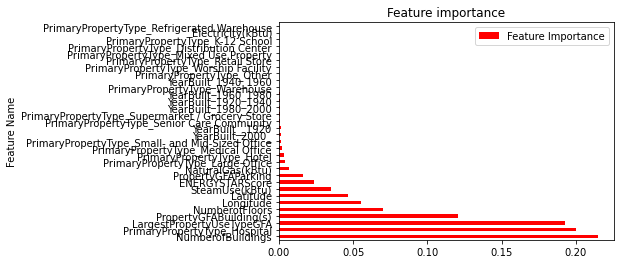

In [258]:
def display_feat_imp_xgboost(boosted):
  feat_imp = model.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = Xe_train.columns
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 
display_feat_imp_xgboost(model)

- <a name='C2'> LIME </a>

In [259]:
reversed_Xe_train = undummify(Xe_train)
reversed_Xe_test =undummify(Xe_test)

In [260]:
label_encoder3 = LabelEncoder().fit(reversed_Xe_train['PrimaryPropertyType'])
reversed_Xe_train.PrimaryPropertyType = label_encoder3.transform(reversed_Xe_train['PrimaryPropertyType'])
reversed_Xe_test.PrimaryPropertyType = label_encoder3.transform(reversed_Xe_test['PrimaryPropertyType'])

In [261]:
label_encoder4 = LabelEncoder().fit(reversed_Xe_train['YearBuilt'])
reversed_Xe_train.YearBuilt = label_encoder4.transform(reversed_Xe_train['YearBuilt'])
reversed_Xe_test.YearBuilt = label_encoder4.transform(reversed_Xe_test['YearBuilt'])

In [262]:
CV_xgboost_ESS.fit(reversed_Xe_train, ye_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [0]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [263]:
ESS_explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(reversed_Xe_train),
                                                   feature_names=reversed_Xe_train.columns,
                                                   mode="regression",
                                                   feature_selection='auto',
                                                   random_state=0)

In [264]:
ESS_exp = ESS_explainer.explain_instance(data_row=pd.DataFrame(reversed_Xe_test).iloc[10],
                                           predict_fn=CV_xgboost_ESS.predict)

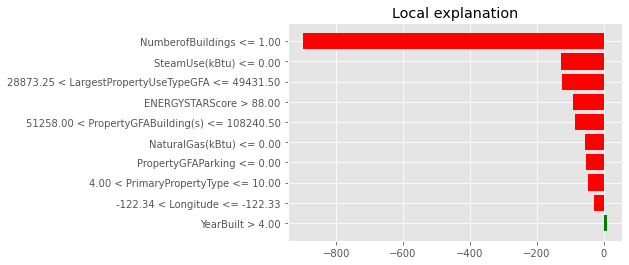

In [265]:
with plt.style.context("ggplot"):
    ESS_exp.as_pyplot_figure()

In [266]:
ESS_exp.show_in_notebook(show_table=True)

- <a name='C2'> SHAP </a>

In [267]:
ES_shap_model = CV_xgboost_ESS.best_estimator_
ES_shap_explainer  = shap.TreeExplainer(ES_shap_model,reversed_Xe_train)

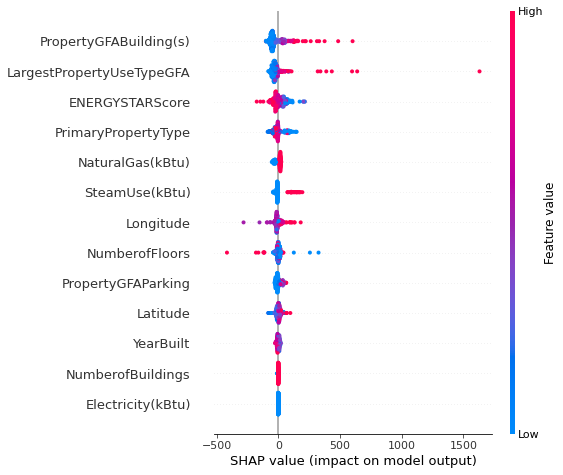

In [268]:
shap_values = ES_shap_explainer(reversed_Xe_test,check_additivity = False)
shap.summary_plot(shap_values, feature_names=reversed_Xe_train.columns)
plt.show()

- Sans Energy Star Score

In [269]:
train_S_ESS, test_S_ESS = train_test_split(df_EES_encoded, test_size=0.33, random_state=2) 

In [270]:
Xee_train, yee_train, Xee_test, yee_test = train_S_ESS.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)",'ENERGYSTARScore']), train_S_ESS["TotalGHGEmissions"], test_S_ESS.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)",'ENERGYSTARScore']) , test_S_ESS["TotalGHGEmissions"]

In [271]:
""" scaler = StandardScaler()
scaler.fit(Xee_train_ghge)
Xee_train_ghge = scaler.transform(Xee_train_ghge)
Xee_test_ghge = scaler.transform(Xee_test_ghge) """

' scaler = StandardScaler()\nscaler.fit(Xee_train_ghge)\nXee_train_ghge = scaler.transform(Xee_train_ghge)\nXee_test_ghge = scaler.transform(Xee_test_ghge) '

In [272]:
#xGBoost_S_ESS = GradientBoostingRegressor(**CV_xgboost.best_params_)

In [273]:
#xGBoost_S_ESS.fit(Xee_train,yee_train)

In [295]:
CV_xGBoost_S_ESS = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_xGBoost_S_ESS.fit(Xee_train, yee_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [0]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [296]:
CV_xGBoost_S_ESS.best_score_

0.7192272695755692

In [297]:
CV_xGBoost_S_ESS.score(Xee_test,yee_test)

0.591293407502592

In [298]:
print(f"Validation Score: {round(CV_xGBoost_S_ESS.best_score_*100,1)} %")
print(f"Score - training data: {round(CV_xGBoost_S_ESS.score(Xee_train,yee_train)*100,1)} %")
print(f"Score - test data: {round(CV_xGBoost_S_ESS.score(Xee_test,yee_test)*100,1)} %")

Validation Score: 71.9 %
Score - training data: 99.6 %
Score - test data: 59.1 %


    Feature Importance                                     Feature Name
11        2.552806e-01                     PrimaryPropertyType_Hospital
2         2.442274e-01                                NumberofBuildings
4         1.928600e-01                           PropertyGFABuilding(s)
6         9.748537e-02                        LargestPropertyUseTypeGFA
3         6.184439e-02                                   NumberofFloors
1         3.340510e-02                                        Longitude
7         3.022250e-02                                   SteamUse(kBtu)
14        2.180888e-02                 PrimaryPropertyType_Large Office
0         2.045849e-02                                         Latitude
28        1.883806e-02                              YearBuilt_1980_2000
9         8.017173e-03                                 NaturalGas(kBtu)
26        4.045127e-03                              YearBuilt_1940_1960
5         2.373772e-03                               PropertyGFA

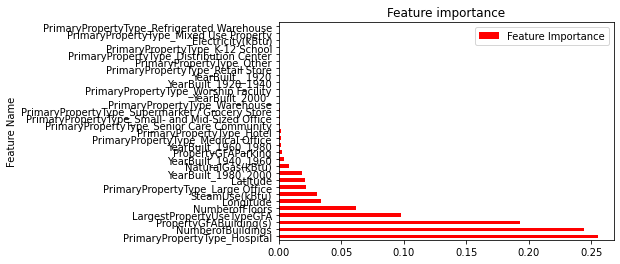

In [299]:
def display_feat_imp_xgboost(boosted):
  feat_imp = CV_xGBoost_S_ESS.best_estimator_.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = Xee_train.columns
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 
display_feat_imp_xgboost(CV_xGBoost_S_ESS.best_estimator_)

- <a name='C2'> LIME </a>

In [300]:
reversed_Xee_train = undummify(Xee_train)
reversed_Xee_test =undummify(Xee_test)

In [301]:
label_encoder5 = LabelEncoder().fit(reversed_Xee_train['PrimaryPropertyType'])
reversed_Xee_train.PrimaryPropertyType = label_encoder5.transform(reversed_Xee_train['PrimaryPropertyType'])
reversed_Xee_test.PrimaryPropertyType = label_encoder5.transform(reversed_Xee_test['PrimaryPropertyType'])

In [302]:
label_encoder6 = LabelEncoder().fit(reversed_Xee_train['YearBuilt'])
reversed_Xee_train.YearBuilt = label_encoder6.transform(reversed_Xee_train['YearBuilt'])
reversed_Xee_test.YearBuilt = label_encoder6.transform(reversed_Xee_test['YearBuilt'])

In [303]:
CV_xGBoost_S_ESS.fit(reversed_Xee_train, yee_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [0]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [304]:
S_ESS_explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(Xee_train),
                                                   feature_names=Xee_train.columns,
                                                   mode="regression",
                                                   feature_selection='auto',
                                                   random_state=0)

- <a name='C2'> SHAP </a>

In [306]:
SES_shap_model = CV_xGBoost_S_ESS.best_estimator_
SES_shap_explainer  = shap.TreeExplainer(SES_shap_model,reversed_Xee_train)

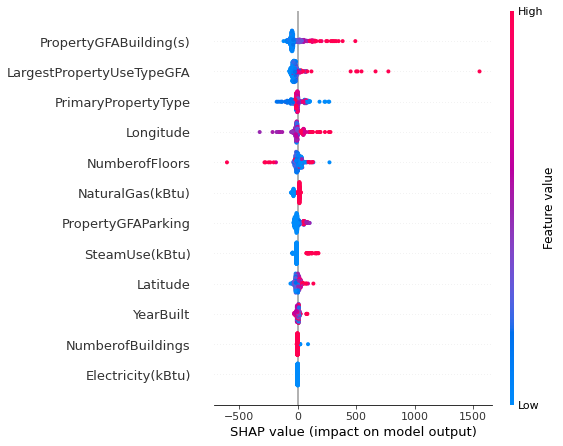

In [307]:
shap_values = SES_shap_explainer(reversed_Xee_test,check_additivity = False)
shap.summary_plot(shap_values, feature_names=reversed_Xee_train.columns)
plt.show()